In [6]:
seed = 0
import torch
torch.manual_seed(seed)
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

In [7]:
import torch
from torch import Tensor
from torch_geometric.logging import init_wandb, log
from torch_geometric.datasets import Planetoid
from utils import train, test, edgeindex2adj
from models import GCN, GAT, LP
citeseer = Planetoid(root='.', name='Citeseer')
cora = Planetoid(root='.', name='Cora')
pubmed = Planetoid(root='.', name='Pubmed')

In [8]:
# dataset = citeseer
# model = GCN(dataset.num_features, 24, dataset.num_classes)

# dataset = cora
# model = GCN(dataset.num_features, 8, dataset.num_classes)

# dataset = pubmed
# model = GCN(dataset.num_features, 8, dataset.num_classes)

# dataset = citeseer
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=4)

# dataset = cora
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=4)

# dataset = pubmed
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=4)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [9]:
from models import ALP, GCN
dataset = cora
data = dataset[0]

In [18]:


# take k random training nodes for each class
k = 3
for c in data.y.unique():
    idx = ((data.y == c) & data.train_mask).nonzero(as_tuple=False).view(-1)
    idx = idx[torch.randperm(idx.size(0))]
    idx = idx[k:]
    data.train_mask[idx] = False

print(data.train_mask.sum())

tensor(21)


In [13]:
# run for 5 seeds
av_acc = 0

for seed in range(5):
    torch.manual_seed(seed)
    model = GCN(dataset.num_features, 8, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=50, min_lr=0.0001)

    best_val_acc = final_test_acc = 0
    for epoch in range(1, 250):
        loss = train(model, data, optimizer, scheduler=None, loss='smooth_label', alpha=20)
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch % 25 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    print(f'Best Val Acc: {best_val_acc:.4f}', f'Test Acc: {test_acc:.4f}')
    av_acc += test_acc
print(f'Average Test Acc: {av_acc/5:.4f}')

Epoch: 025, Loss: 1.8628408908843994, Train: 0.3810, Val: 0.1580, Test: 0.2980
Epoch: 050, Loss: 1.802296757698059, Train: 0.3810, Val: 0.1160, Test: 0.2980
Epoch: 075, Loss: 1.7939027547836304, Train: 0.3810, Val: 0.0740, Test: 0.2980
Epoch: 100, Loss: 1.793192744255066, Train: 0.3810, Val: 0.1580, Test: 0.2980


KeyboardInterrupt: 

In [ ]:
# run for 5 seeds
av_acc = 0

for seed in range(5):
    torch.manual_seed(seed)
    model = GCN(dataset.num_features, 8, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=50, min_lr=0.0001)

    best_val_acc = final_test_acc = 0
    for epoch in range(1, 150):
        loss = train(model, data, optimizer, scheduler=scheduler, loss='cross_entropy')
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch % 25 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    print(f'Best Val Acc: {best_val_acc:.4f}', f'Test Acc: {test_acc:.4f}')
    av_acc += test_acc
print(f'Average Test Acc: {av_acc/5:.4f}')

Epoch: 025, Loss: 0.1498504877090454, Train: 1.0000, Val: 0.4900, Test: 0.5050
Epoch: 050, Loss: 0.00931228045374155, Train: 1.0000, Val: 0.5380, Test: 0.5520
Epoch: 075, Loss: 0.007171915378421545, Train: 1.0000, Val: 0.5620, Test: 0.5710
Epoch: 100, Loss: 0.007477668579667807, Train: 1.0000, Val: 0.5600, Test: 0.5710
Epoch: 125, Loss: 0.007068636827170849, Train: 1.0000, Val: 0.5620, Test: 0.5710
Best Val Acc: 0.5740 Test Acc: 0.5910
Epoch: 025, Loss: 0.0841929242014885, Train: 1.0000, Val: 0.4880, Test: 0.5240
Epoch: 050, Loss: 0.009557830169796944, Train: 1.0000, Val: 0.5300, Test: 0.5490
Epoch: 075, Loss: 0.007854974828660488, Train: 1.0000, Val: 0.5440, Test: 0.5590
Epoch: 100, Loss: 0.007982530631124973, Train: 1.0000, Val: 0.5500, Test: 0.5620
Epoch: 125, Loss: 0.007707900833338499, Train: 1.0000, Val: 0.5620, Test: 0.5790
Best Val Acc: 0.5820 Test Acc: 0.5890
Epoch: 025, Loss: 0.1472441405057907, Train: 1.0000, Val: 0.4940, Test: 0.4930
Epoch: 050, Loss: 0.009941385127604008, 

In [6]:
data.edge_index.shape

torch.Size([2, 10556])

In [9]:
num_classes = int(dataset.num_classes)

In [81]:
n = data.x.shape[0]
counts = np.zeros((n,num_classes))
for edge in data.edge_index.T:
    counts[edge[0]][data.y[edge[1]]] +=1 

In [82]:
adj = edgeindex2adj(data.edge_index, n)

In [83]:
preds = model(data.x, data.edge_index)

In [84]:
preds = preds.detach().numpy().argmax(axis=1)

In [99]:
non_label_smooth_node_counts = 0
total_nodes = 0
non_label_smooth_nodes = []
for i in range(n):
    if data.val_mask[i]:
        if preds[i]!=data.y[i]:
            if counts[i][data.y[i]] == adj[i].sum() and adj[i].sum() > 1:
                non_label_smooth_node_counts +=1
                non_label_smooth_nodes.append(i)
        total_nodes +=1
        

In [100]:
adj[160].sum()

tensor(7.)

In [101]:
preds[164], data.y[164]

(4, tensor(0))

In [102]:
counts[160]

array([0., 0., 0., 7., 0., 0., 0.])

In [103]:
len(non_label_smooth_nodes)

24

In [104]:
non_label_smooth_nodes

[160,
 161,
 166,
 167,
 168,
 172,
 240,
 254,
 267,
 299,
 354,
 365,
 380,
 404,
 411,
 432,
 433,
 477,
 512,
 571,
 578,
 614,
 618,
 634]

In [105]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [108]:
for i in [571]:
    print(counts[i])
    for j in G.neighbors(i):
        print(j, data.y[j])
    print("="*20)

[0. 0. 0. 2. 0. 0. 0.]
696 tensor(3)
1570 tensor(3)


ValueError: 'c' argument has 247 elements, which is inconsistent with 'x' and 'y' with size 223.

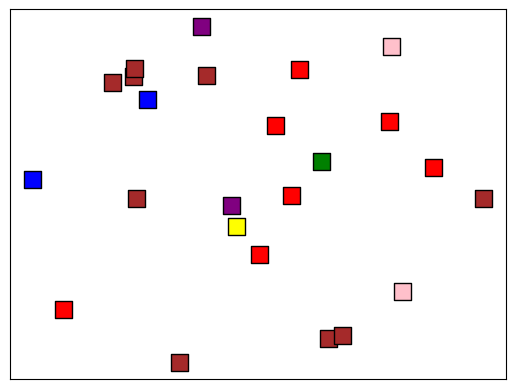

In [137]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

G.add_nodes_from(range(data.num_nodes))

edge_index = data.edge_index.t().tolist()

G.add_edges_from(edge_index)

node_labels = []
level_1_nodes = []
for i in non_label_smooth_nodes:
    for j in G.neighbors(i):
        level_1_nodes.append(j)
for i in level_1_nodes:
    for j in G.neighbors(i):
        node_labels.append(j)
node_labels = list(set(node_labels + level_1_nodes + non_label_smooth_nodes))
new_G = nx.Graph()
new_G.add_nodes_from(node_labels)

new_edge_index = []
for i in node_labels:
    for j in G.neighbors(i):
        if j in node_labels:
            new_edge_index.append([i,j])
new_G.add_edges_from(new_edge_index)


# Get node labels
# node_labels = data.y.tolist()

# Set node color by labels
color_map = ["red", "green", "blue", "yellow", "brown", "purple", "pink", "orange", "grey"]
node_color = [color_map[data.y[label]] if label not in non_label_smooth_nodes else color_map[preds[label]] for label in node_labels]
node_sizes = [150 if label in non_label_smooth_nodes else 20 for label in node_labels]
pos = nx.spring_layout(new_G, k=0.2)
highlight_border_color = 'black'
node_border_color = [highlight_border_color if label in non_label_smooth_nodes else 'none' for label in node_labels]
node_border_width = [10 if label in non_label_smooth_nodes else 0 for label in node_labels]
node_shapes = ['s' if label in non_label_smooth_nodes else 'o' for label in node_labels]
# Draw graph with node color and smaller size
# nx.draw(new_G, pos = pos, node_color=node_color, node_size=node_sizes, width=0.6, edgecolors = node_border_color, node_shape=node_shape, linewidths=node_border_width)
nx.draw_networkx_nodes(new_G, pos=pos, nodelist=non_label_smooth_nodes, node_color = [color_map[preds[label]] for label in non_label_smooth_nodes], node_size=150, node_shape='s', linewidths=1, edgecolors='black')
nx.draw_networkx_nodes(new_G, pos = pos, nodelist = [label for label in node_labels if label not in non_label_smooth_nodes], node_color=[color_map[data.y[label]] for label in node_labels if label not in non_label_smooth_nodes], node_size=20, node_shape='o', linewidths=0)
nx.draw_networkx_edges(new_G, pos=pos, width=0.6, alpha=0.5)

plt.show()

['s',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 's',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 's',
 's',
 's',
 'o',
 'o',
 's',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 's',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o'

In [110]:
node_labels

[512,
 2,
 1542,
 519,
 2569,
 1039,
 1556,
 1558,
 1046,
 1051,
 1054,
 1055,
 1056,
 1570,
 1574,
 40,
 553,
 1065,
 2601,
 1577,
 45,
 2606,
 1583,
 1072,
 2609,
 566,
 2617,
 1082,
 571,
 1597,
 574,
 578,
 68,
 71,
 1095,
 1096,
 1099,
 588,
 77,
 1105,
 87,
 88,
 1630,
 1633,
 1635,
 614,
 1127,
 618,
 1131,
 118,
 634,
 1149,
 638,
 2186,
 2187,
 1166,
 1170,
 659,
 661,
 151,
 1176,
 1692,
 668,
 670,
 160,
 673,
 1697,
 161,
 166,
 167,
 1704,
 681,
 168,
 172,
 1709,
 179,
 2227,
 2229,
 2230,
 2228,
 696,
 1211,
 1221,
 201,
 1239,
 215,
 219,
 737,
 743,
 232,
 745,
 240,
 756,
 1269,
 251,
 253,
 2302,
 254,
 256,
 1475,
 1476,
 260,
 266,
 267,
 1803,
 271,
 1812,
 277,
 1300,
 792,
 2498,
 288,
 291,
 808,
 2345,
 2346,
 2347,
 2348,
 2349,
 812,
 299,
 814,
 1484,
 1839,
 816,
 1332,
 300,
 1334,
 314,
 1488,
 320,
 1859,
 2373,
 1999,
 2508,
 842,
 1869,
 1870,
 335,
 2383,
 1873,
 2382,
 1875,
 1876,
 2387,
 1363,
 2386,
 1879,
 354,
 365,
 366,
 878,
 885,
 1399,
 88

In [61]:
len(node_color), len(node_labels)

(414, 414)

NodeView((2, 13, 14, 27, 2084, 38, 41, 45, 2095, 49, 55, 60, 2112, 68, 69, 71, 2120, 2122, 2130, 85, 86, 88, 94, 2144, 102, 104, 109, 112, 2165, 2166, 118, 126, 133, 137, 139, 141, 2189, 146, 2195, 2194, 151, 153, 158, 159, 160, 2210, 2211, 164, 175, 179, 181, 2230, 201, 210, 215, 218, 2268, 224, 2274, 230, 232, 2291, 2301, 2302, 255, 2303, 2304, 2309, 267, 2316, 2318, 2319, 2320, 2321, 279, 2330, 2331, 285, 2360, 2361, 314, 317, 2367, 2371, 331, 332, 334, 335, 2388, 350, 351, 356, 366, 377, 382, 383, 384, 388, 2436, 391, 397, 398, 401, 2450, 407, 409, 411, 415, 417, 435, 446, 452, 454, 459, 460, 471, 476, 481, 482, 506, 510, 511, 2559, 514, 516, 519, 530, 531, 542, 549, 554, 556, 566, 568, 576, 581, 589, 594, 596, 604, 608, 617, 644, 660, 661, 663, 673, 674, 678, 681, 691, 695, 711, 712, 716, 717, 719, 733, 743, 745, 759, 767, 778, 779, 790, 791, 792, 794, 795, 808, 818, 827, 830, 835, 836, 841, 842, 860, 862, 863, 864, 880, 887, 897, 899, 908, 910, 921, 948, 955, 962, 963, 968, 980, 

In [ ]:
# dataset = citeseer
# dataset = cora
dataset = pubmed

best_val_acc = final_test_acc = 0
best_l = best_a = 0

for l in [1, 2, 4, 8, 16, 32]:
    for a in [0.05, 0.1, 0.3, 0.6, 0.8, 0.9, 0.95, 0.99, 1]:
        model = LP(num_layers=l, alpha=a)
        outs = model.train(dataset)
        train_acc, val_acc, tmp_test_acc = model.test()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
            best_l = l
            best_a = a
            
print(f'Best Val Acc: {best_val_acc:.4f}', f'Test Acc: {test_acc:.4f}', f'Best l: {best_l}', f'Best a: {best_a}')

Best Val Acc: 0.7260 Test Acc: 0.7140 Best l: 16 Best a: 0.99


In [ ]:
accs = model.test()
accs

[0.8833333333333333, 0.712, 0.707]

In [ ]:
outs.shape

torch.Size([19717, 3])

In [ ]:
outs.argmax(dim=-1)

tensor([1, 1, 0,  ..., 2, 0, 2])

In [ ]:
dataset[0].y

tensor([1, 1, 0,  ..., 2, 0, 2])

In [ ]:
dataset.num_classes

3